In [1]:
import os
import sys
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from viz.graphs import plot_vertical_bars_errors, plot_heatmap, plot_bargraph, plot_bargraph_labels, plot_loglog
from viz.graphs import plot_histogram_bins
from viz.radar import Radar

%matplotlib inline

In [2]:
# Functions to load data from the csv files
def get_algo_names(csv_file):
    df = pd.read_csv(csv_file)
    return df['Algorithm']

def get_real_time(csv_file):
    df = pd.read_csv(csv_file)
    return df['User']

def get_real_time_algos(algorithms, csv_file):
    df = pd.read_csv(csv_file)
    times = []
    errs = []
    for alg in algorithms:
        alg_filter = df['Algorithm'] == alg 
        filtered_df = df[alg_filter]
        time = np.mean(filtered_df['User'].values[1:])
        err = np.std(filtered_df['User'].values[1:])
        times += [time]
        errs += [err]
    return times, errs

In [3]:
# Generic function to plot a graph vertically stacked bars
def vertical_stack_bars_errors(name, benchmark, files):
    orderings = ()
    dataset = ""
    for f in files:
        bname = os.path.basename(f)
        tokens = bname.split('-')
        dataset = bname.split('-')[0]
        ordering = bname.split('-')[1].split('.')[0]
        if dataset == "soc":
            ordering = bname.split('-')[2].split('.')[0]
        orderings = orderings + (ordering,)
    names_col = get_algo_names(files[0])
    names_col = np.unique(names_col)
    algorithms = ()
    for n in names_col:
        algorithms = algorithms + (n,)
    time_cols = []
    err_cols = []
    for f in files:
        time_col, err_col = get_real_time_algos(names_col, f)
        time_cols += [time_col]
        err_cols += [err_col]
    data = []
    err_data = []
    for i in range(len(orderings)):
        col = []
        err_col = []
        for t in time_cols[i]:
            col += [t]
        for e in err_cols[i]:
            err_col += [e]
        data += [col]
        err_data += [err_col]
    plot_vertical_bars_errors(name + "_" + benchmark + "_" + dataset, data, algorithms, orderings, "Runtime (in s)", (8,4), "Algorithms", err_data)

    
def plot_cache(name, csv_file):
    df = pd.read_csv(csv_file)
    unique_orderings = df.Ordering.unique()
    unique_algs = df.Algo.unique()
    data = []
    err_data = []
    for o in unique_orderings:
        rows = df.loc[df['Ordering'] == o]
        ordering_data = []
        ordering_err_data = []
        for alg in unique_algs:
            refined_rows = rows.loc[rows['Algo'] == alg]
            miss_rates = refined_rows['Misses']/refined_rows['Refs']
            avg_rate = np.average(miss_rates)
            ordering_data += [avg_rate]
            ordering_err_data += [np.std(miss_rates)]
        data += [ordering_data]
        err_data += [ordering_err_data]
    plot_vertical_bars_errors(name, data, unique_algs, unique_orderings, "Cache Miss Rate", (8,4), "Algorithms", err_data)
    
    
def plot_bars_with_errors(name, benchmark, datafile_base, suffixes):
    files = []
    for s in suffixes:
        files += [datafile_base + s + "-" + benchmark + ".csv"]
    vertical_stack_bars_errors(name, benchmark, files)
    
def plot_comparison(name, isomorphism, datafile_base, benchmark):
    files = []
    files += [datafile_base + "-" + isomorphism + "-" + benchmark + ".csv"]
    files += [datafile_base + "-" + isomorphism + "_nz-" + benchmark + ".csv"]
    vertical_stack_bars_errors(name, benchmark + "-" + isomorphism + "comparison", files)

# Graph Processing Systems

[   0.   72.  144.  216.  288.]


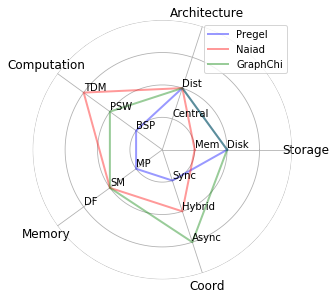

In [4]:
fig = plt.figure(figsize=(8, 4)) 

title = ["Storage", "Architecture", "Computation", "Memory", "Coord"]

lab = [ 
    ["Mem", "Disk", " "],
    ["Central", "Dist", " "],
    ["BSP", "PSW", "TDM"],
    ["MP", "SM", "DF"],
    ["Sync", "Hybrid", "Async"]
]   

radar = Radar(fig, title, lab)
radar.plot([2,2,1,1,1],  '-', lw=2, color='b', alpha=0.4, label='Pregel')
radar.plot([1,2,3,2,2], '-', lw=2, color='r', alpha=0.4, label='Naiad')
radar.plot([2,2,2,2,3], '-', lw=2, color='g', alpha=0.4, label='GraphChi')
radar.ax.legend()

fig.savefig('Systems.png')
plt.show()

# Benchmarking across Conferences

All conferences until 2018 are included in the results.

In [4]:
def heatmap(name, csv_file, inverty=True, takeAvg=False):
    df = pd.read_csv(csv_file)
    col_names = list(df.columns.values)
    # Remove the Unnamed column name
    col_names = col_names[1:]
    row_names = df.iloc[:,0].tolist()
    data = df.values[:,1:].astype(float)
    if takeAvg:
        data = data / data.sum(axis=0)
    plot_heatmap(name,data,col_names, row_names, inverty)

In [5]:
def bargraph(name, csv_file):
    df = pd.read_csv(csv_file)
    vals = df['Total']
    plot_bargraph(name, vals.sort_values(ascending=False), name + " in sorted order", "Count")

In [6]:
def bargraph_labels(name, csv_file, col1, col2):
    df = pd.read_csv(csv_file)
    vals = df[col1]
    labels = df[col2]
    plot_bargraph_labels(name, vals, labels, name, col1)

## Papers across Conferences

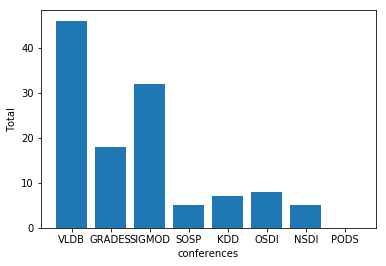

In [8]:
bargraph_labels("conferences", "../data/conferences-total.csv", "Total", "Conference")
plt.show()

## Dataset Usage Distribution

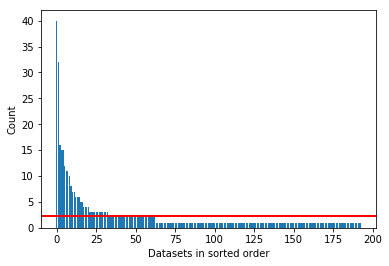

In [7]:
bargraph("Datasets", "../data/datasets_total.csv")
plt.show()

## Benchmark Usage Distribution

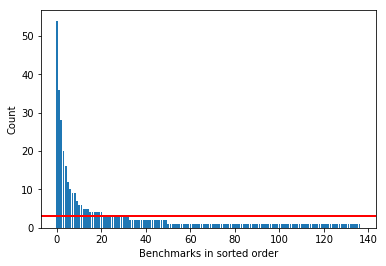

In [8]:
bargraph("Benchmarks", "../data/benchmarks_total.csv")
plt.show()

## Benchmarks per paper

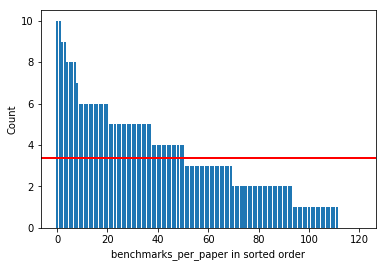

In [11]:
bargraph("benchmarks_per_paper", "../data/benchmarks_per_paper.csv")
plt.show()

## Datasets Per Paper

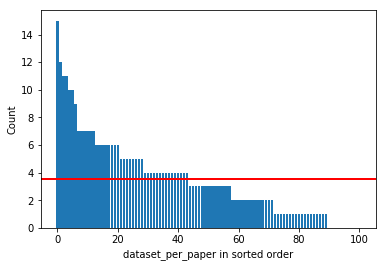

In [12]:
bargraph("dataset_per_paper", "../data/datasets_per_paper.csv")
plt.show()

## Dataset Distribution per Conference

Each cell indicates what percentage of selected papers from that conference used that specific dataset

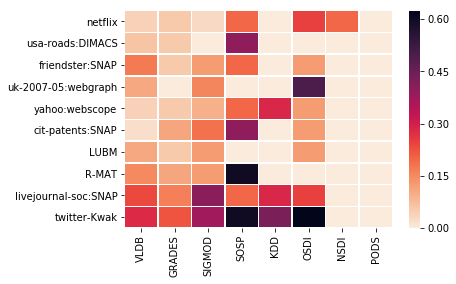

In [13]:
heatmap("datasets_vs_conf", "../data/datasets_vs_conf.csv")
plt.show()

## Benchmark Distribution per Conference

Each cell indicates what percentage of selected papers from that conference used that specific benchmark

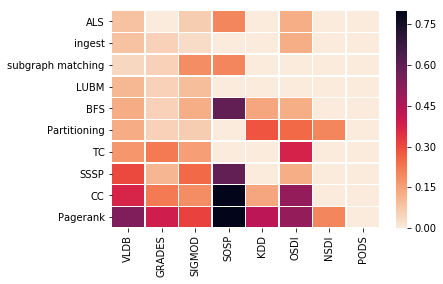

In [14]:
heatmap("benchmarks_vs_conf", "../data/benchmarks_vs_conf.csv")
plt.show()

## Benchmarks-Datasets co-citation

Each cell indicates the total number of papers in which both the dataset and benchmark were used

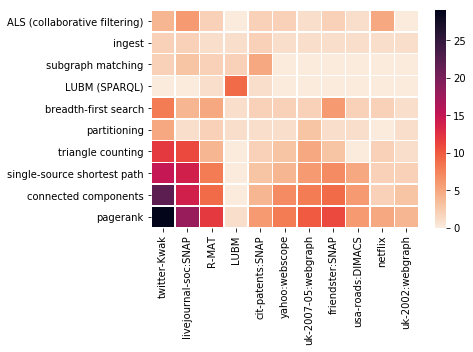

In [15]:
heatmap("benchmarks_vs_datasets", "../data/benchmarks_vs_datasets_small.csv")
plt.show()

# Experimental Setup + Intro

We show results for 4 different isomorphisms - default, degree, revdegree, and bfs.

We also show results for all the benchmarks after removing the zero degree vertices.

To showcase the effect of the zero degree vertices, we also show the random isomorphism.

The results shown are average results from 24 iterations of running the benchmark.

Before the results were collected, the cache was warmed up by running the dataset through the
benchmark once so as to eliminate the initial cache load time.

## Benchmarks

### PageRank

4 different algorithms are provided by Galois 3.0

### Connected Components

7 different algorithms are provided by Galois 3.0

### Triangle Counting

2 different algorithms are provided by Galois 3.0

## Datasets

### Notes

+ Smooth Kronecker indeed does work for smoothening the power law graph
+ It seems like the generated datasets don't model the distribution of zero degree vertices across the node IDs realistically. Smooth Kronecker seems to suffer from this as well. Not sure what's the best way of proving this fact.

In [2]:
def loglog(name, csv_file):
    df = pd.read_csv(csv_file)
    x = df['Degree']
    y = df['Count']
    plot_loglog(name, x, y, "Degree", "Frequency")

def hist(name, csv_file):
    df = pd.read_csv(csv_file)
    data = df['Zero_Vertices']
    print(len(data))
    unit = int(0.01 * len(data))
    bins = np.arange(0, len(data), unit)
    plot_histogram_bins(name, data, bins, 'Node Id range', 'Count')
    
def gscatter(name,csv_file):
    df = pd.read_csv(csv_file)
    x = df['Ids']
    y = df['Degree']
    plt.plot(x,y,'b-')
    plt.xlabel('Vertex ID')
    plt.ylabel('Degree')
    plt.savefig(name + ".png", bbox_inches="tight")


## Twitter

### Stats

+ MAX_VERTEX=61578414
+ MIN_VERTEX=12
+ VERTEX_COUNT=41652230
+ EDGE_COUNT=1468365182
+ ISOLATED_VERTICES=19926184
+ Percentage of Isolated Vertices=47.8394
+ RMATSMALL_S=25
+ RMATSMALL_E=44
+ RMATBIG_S=26
+ RMATBIG_E=22

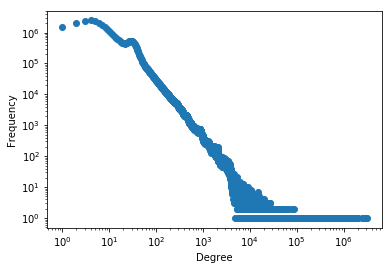

19926185


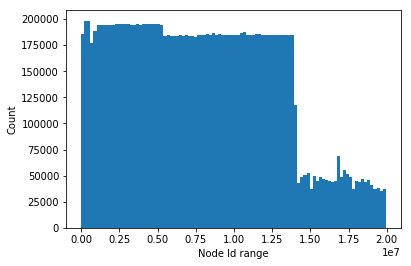

In [17]:
loglog("twitter_degrees", "../preprocessor/degrees_twitter_rv.csv")
plt.show()
hist("twitter_zero", "../preprocessor/isolated_twitter_rv.csv")
plt.show()

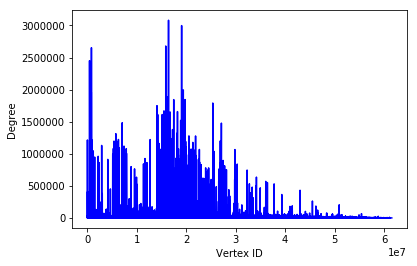

In [18]:
gscatter("twitter_rv_id_degree_dist", "../preprocessor/edgedeg_twitter_rv.csv")
plt.show()

## Cit Patents

### Stats

+ MAX_VERTEX=6009554
+ MIN_VERTEX=1
+ VERTEX_COUNT=3774768
+ EDGE_COUNT=16518948
+ ISOLATED_VERTICES=2234786
+ Percentage of Isolated Vertices=59.2033%
+ RMATSMALL_S=21
+ RMATSMALL_E=8
+ RMATBIG_S=22
+ RMATBIG_E=4

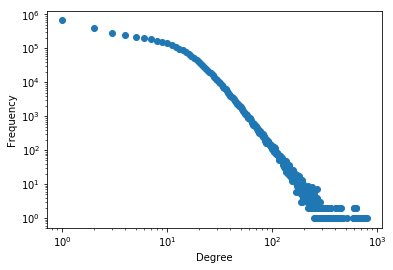

Zero Degree vertices distribution
2234787


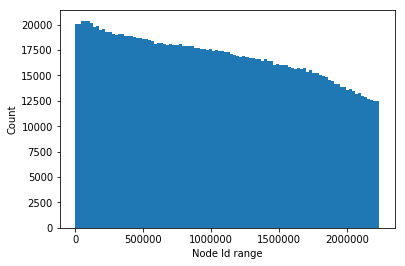

In [19]:
loglog("cit_degrees", "../preprocessor/degrees_cit_patents.csv")
plt.show()
print("Zero Degree vertices distribution")
hist("cit_zero", "../preprocessor/isolated_cit_patents.csv")
plt.show()

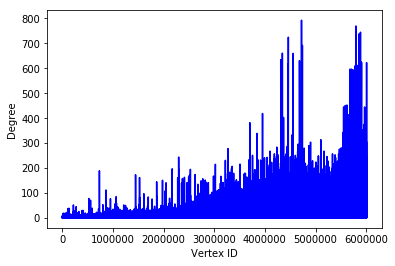

In [20]:
gscatter("cit_patents_id_degree_dist", "../preprocessor/edgedeg_cit_patents.csv")
plt.show()

## Soc LiveJournal

### Stats

+ MAX_VERTEX=4847570
+ MIN_VERTEX=0
+ VERTEX_COUNT=4847571
+ EDGE_COUNT=68993773
+ ISOLATED_VERTICES=0
+ Percentage of Isolated Vertices=0.000000
+ RMATSMALL_S=22
+ RMATSMALL_E=16
+ RMATBIG_S=23
+ RMATBIG_E=8


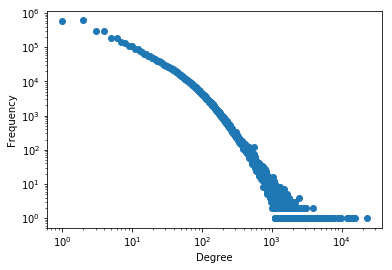

In [21]:
loglog("soc_degrees", "../preprocessor/degrees_soc_livejournal.csv")
plt.show()

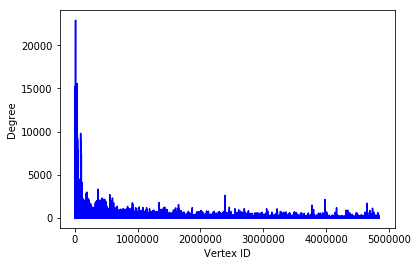

In [22]:
gscatter("soc_livejournal_id_degree_dist", "../preprocessor/edgedeg_soc_livejournal.csv")
plt.show()

## Smooth Kronecker

Generated using https://github.com/dmargo/smooth_kron_gen

### Stats

+ MAX_VERTEX=393091
+ MIN_VERTEX=0
+ VERTEX_COUNT=334279
+ EDGE_COUNT=20000000
+ ISOLATED_VERTICES=58812
+ Percentage of Isolated Vertices=17.5937%
+ RMATSMALL_S=18
+ RMATSMALL_E=76
+ RMATBIG_S=19
+ RMATBIG_E=38

### Issue

+ Smooth Kronecker fixes the degree distribution by smoothening

+ Distribution of Zero Vertices across Node IDs is not fixed

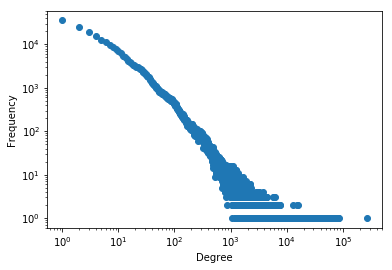

Zero Degree vertices distribution
58813


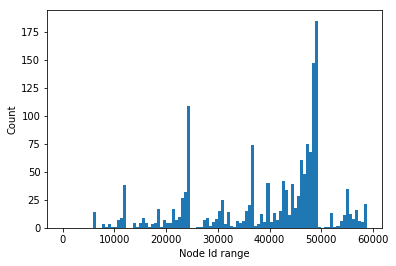

In [23]:
loglog("kron_degrees", "../preprocessor/degrees_kron.csv")
plt.show()
print("Zero Degree vertices distribution")
hist("kron_zero", "../preprocessor/isolated_kron.csv")
plt.show()

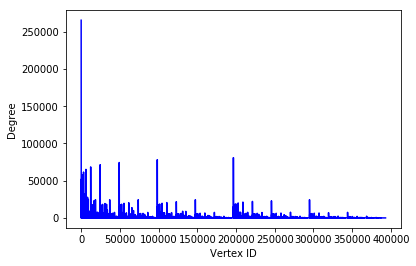

In [24]:
gscatter("kron_id_degree_dist", "../preprocessor/edgedeg_kron.csv")
plt.show()

### More smooth kroneker graphs

#### S2 = 16, E= 16, S3=0

+ Scale2 : 16
+ Scale3 : 0
+ Edges : 1048576
+ Nodes (with Zero) : 65457
+ Nodes (without Zero) : 46745
+ Hypothesis : Must see combing effect

#### S2 = 16, E = 16, S3 = 5

+ Scale2 : 16
+ Scale3 : 5
+ Edges : 1048756
+ Nodes (with Zero) : 15912833
+ Nodes (w/o Zero) : 927621
+ Hypothesis : Should not see combing effect

#### S2 = 8, E =16, S3 = 5

+ Scale2 : 8
+ Scale3 : 5
+ Edges : 1048756
+ Nodes (with Zero): 62100 
+ Nodes (w/o Zero) : 48810
+ Hypothesis : Should not see combing effect

THIS IS THE ONE WE NEED TO BE USING FOR COMPARISON WITH THE REST OF RMAT SHIT

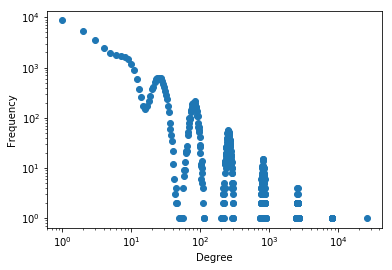

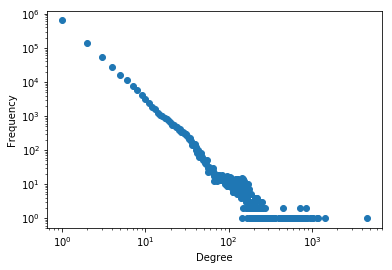

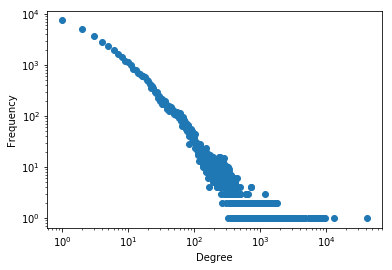

In [5]:
loglog("kron_16_16_degrees", "../preprocessor/degrees_kron_16_16.csv")
plt.show()
loglog("kron_16_16_5_degrees", "../preprocessor/degrees_kron_16_16_5.csv")
plt.show()
loglog("kron_8_16_5_degrees", "../preprocessor/degrees_kron_8_16_5.csv")
plt.show()

## PaRMAT

Generated using https://github.com/farkhor/PaRMAT

### Stats

+ MAX_VERTEX=65481
+ MIN_VERTEX=0
+ VERTEX_COUNT=48501
+ EDGE_COUNT=1048576
+ ISOLATED_VERTICES=16980
+ Percentage of Isolated Vertices=35.0096%
+ RMATSMALL_S=15
+ RMATSMALL_E=32
+ RMATBIG_S=16
+ RMATBIG_E=16

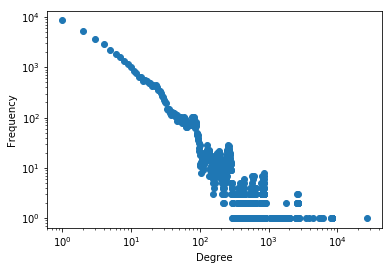

Zero Degree vertices distribution
16981


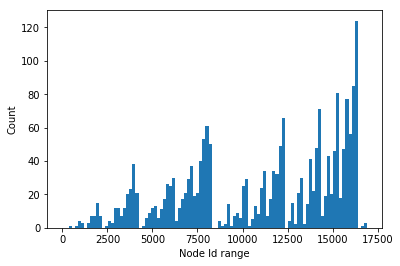

In [25]:
loglog("parmat_degrees", "../preprocessor/degrees_parmat.csv")
plt.show()
print("Zero Degree vertices distribution")
hist("parmat_zero", "../preprocessor/isolated_parmat.csv")
plt.show()

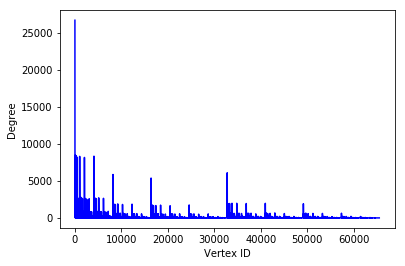

In [26]:
gscatter("parmat_id_degree_dist", "../preprocessor/edgedeg_parmat.csv")
plt.show()

## LigraRMAT

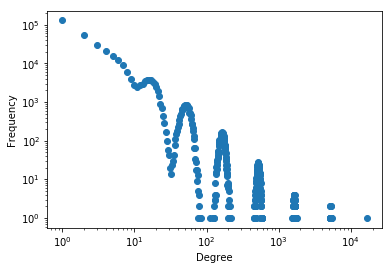

In [27]:
loglog("ligrarmat_degrees", "../preprocessor/degrees_ligrarmat.csv")
plt.show()

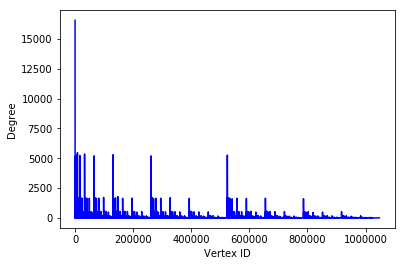

In [28]:
gscatter("ligrarmat_id_degree_dist", "../preprocessor/edgedeg_ligrarmat.csv")
plt.show()

# Results - Gemini

In [29]:
suffixes = ["-default", "-degree", "-revdegree"]
nz_suffixes = ["-default_nz", "-degree_nz", "-revdegree_nz"]

## Twitter

PageRank


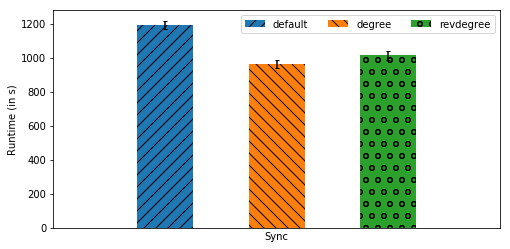

Connected Components


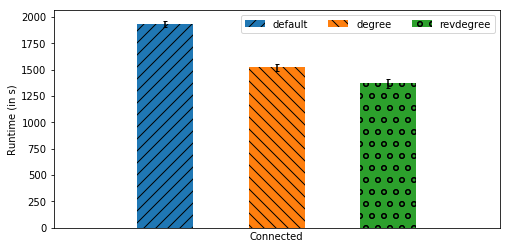

In [30]:
datafile_base = "../scripts/gemini/stats/twitter_rv/twitter_rv"
benchmarks = ["pr", "cc"]
full_names = {"pr" : "PageRank", "cc" : "Connected Components"}
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("gemini", benchmark, datafile_base, suffixes)
    plt.show()

### Caching

PageRank


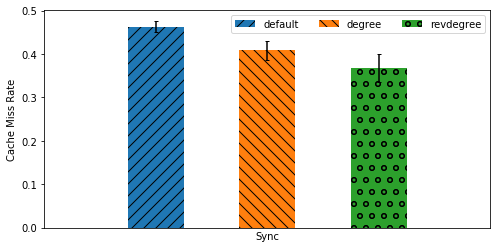

Connected Components


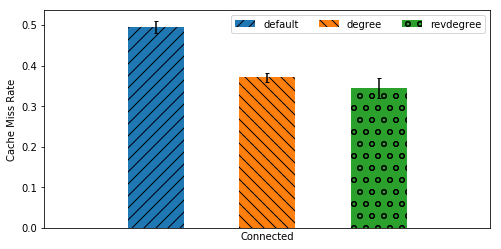

In [31]:
datafile = "../scripts/gemini/stats/twitter_rv/twitter_rv_pr_cache.csv"
print("PageRank")
plot_cache('gemini_twitter_rv_pr_cache', datafile)
plt.show()
print("Connected Components")
datafile = "../scripts/gemini/stats/twitter_rv/twitter_rv_cc_cache.csv"
plot_cache('gemini_twitter_rv_cc_cache', datafile)
plt.show()

## Cit_Patents

PageRank


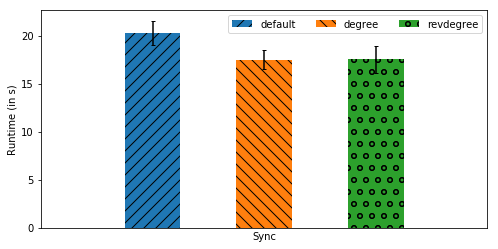

Connected Components


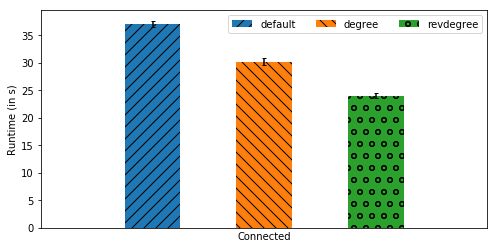

In [32]:
datafile_base = "../scripts/gemini/stats/cit_patents/cit_patents"
benchmarks = ["pr", "cc"]
full_names = {"pr" : "PageRank", "cc" : "Connected Components"}
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("gemini", benchmark, datafile_base, suffixes)
    plt.show()

### Caching

PageRank


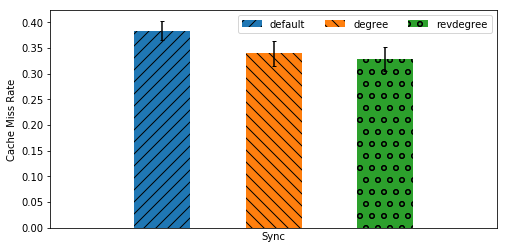

Connected Components


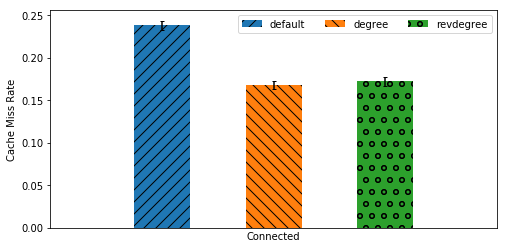

In [33]:
datafile = "../scripts/gemini/stats/cit_patents/cit_patents_pr_cache.csv"
print("PageRank")
plot_cache('gemini_cit_patents_pr_cache', datafile)
plt.show()
print("Connected Components")
datafile = "../scripts/gemini/stats/cit_patents/cit_patents_cc_cache.csv"
plot_cache('gemini_cit_patents_cc_cache', datafile)
plt.show()

## Kron

PageRank


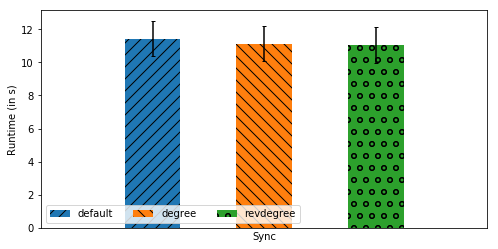

Connected Components


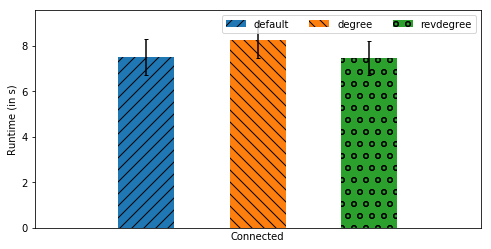

In [34]:
datafile_base = "../scripts/gemini/stats/kron/kron"
benchmarks = ["pr", "cc"]
full_names = {"pr" : "PageRank", "cc" : "Connected Components"}
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("gemini", benchmark, datafile_base, suffixes)
    plt.show()

### Caching

PageRank


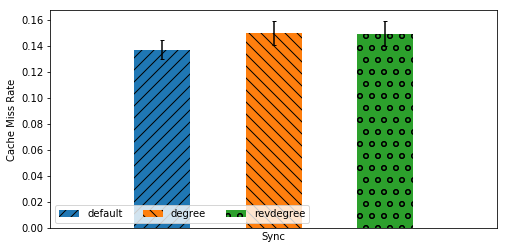

Connected Components


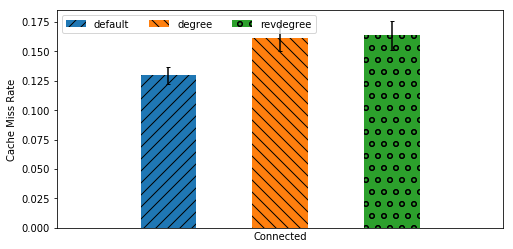

In [35]:
datafile = "../scripts/gemini/stats/kron/kron_pr_cache.csv"
print("PageRank")
plot_cache('gemini_kron_pr_cache', datafile)
plt.show()
print("Connected Components")
datafile = "../scripts/gemini/stats/kron/kron_cc_cache.csv"
plot_cache('gemini_kron_cc_cache', datafile)
plt.show()

## Parmat

PageRank


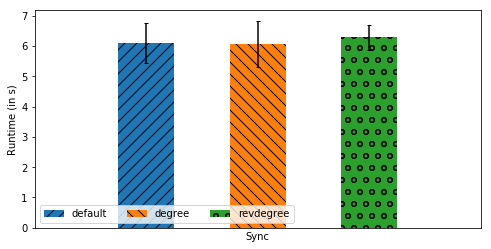

Connected Components


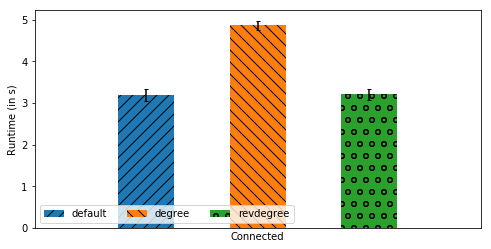

In [36]:
datafile_base = "../scripts/gemini/stats/parmat/parmat"
benchmarks = ["pr", "cc"]
full_names = {"pr" : "PageRank", "cc" : "Connected Components"}
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("gemini", benchmark, datafile_base, suffixes)
    plt.show()

### Caching

PageRank


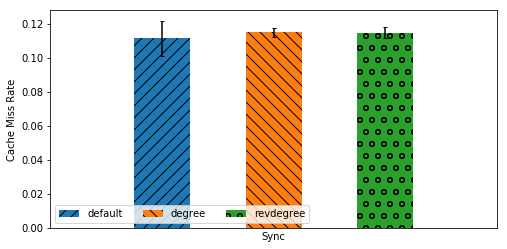

Connected Components


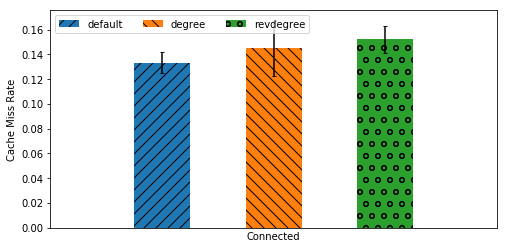

In [37]:
datafile = "../scripts/gemini/stats/parmat/parmat_pr_cache.csv"
print("PageRank")
plot_cache('gemini_parmat_pr_cache', datafile)
plt.show()
print("Connected Components")
datafile = "../scripts/gemini/stats/parmat/parmat_cc_cache.csv"
plot_cache('gemini_parmat_cc_cache', datafile)
plt.show()

## Soc-Livejournal

PageRank


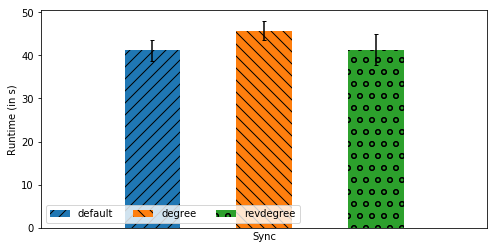

Connected Components


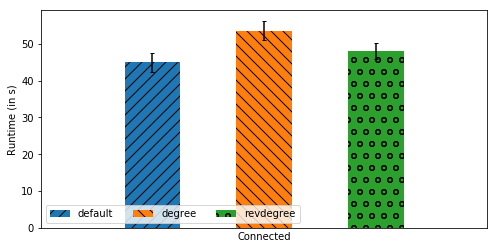

In [38]:
datafile_base = "../scripts/gemini/stats/soc_livejournal/soc-livejournal"
benchmarks = ["pr", "cc"]
full_names = {"pr" : "PageRank", "cc" : "Connected Components"}
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("gemini", benchmark, datafile_base, suffixes)
    plt.show()

### Caching

PageRank


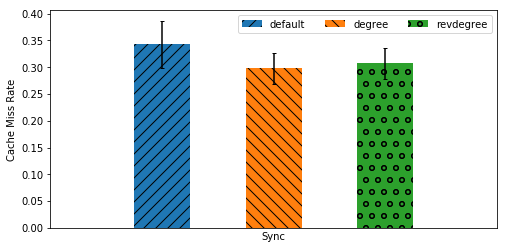

Connected Components


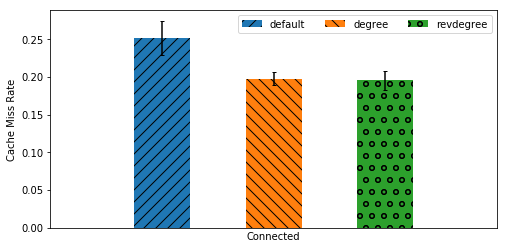

In [39]:
datafile = "../scripts/gemini/stats/soc_livejournal/soc-livejournal_pr_cache.csv"
print("PageRank")
plot_cache('gemini_soc_livejournal_pr_cache', datafile)
plt.show()
print("Connected Components")
datafile = "../scripts/gemini/stats/soc_livejournal/soc-livejournal_cc_cache.csv"
plot_cache('gemini_soc_livejournal_cc_cache', datafile)
plt.show()

# Results - GraphChi

In [4]:
suffixes = ["-default", "-degree", "-revdegree"]
nz_suffixes = ["-default_nz", "-degree_nz", "-revdegree_nz"]

## Twitter

PageRank


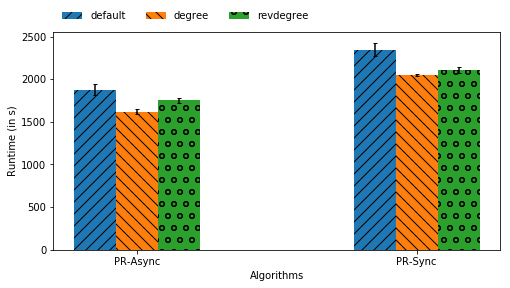

In [5]:
datafile_base = "../scripts/graphchi/stats/twitter_rv/twitter_rv"
benchmarks = ["pr"]
full_names = {"pr" : "PageRank"}
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("graphchi", benchmark, datafile_base, suffixes)
    plt.show()

## Cit_Patents

PageRank


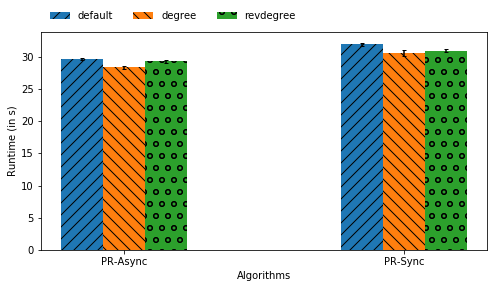

In [42]:
datafile_base = "../scripts/graphchi/stats/cit_patents/cit_patents"
benchmarks = ["pr"]
full_names = {"pr" : "PageRank"}
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("graphchi", benchmark, datafile_base, suffixes)
    plt.show()

## Kron

PageRank


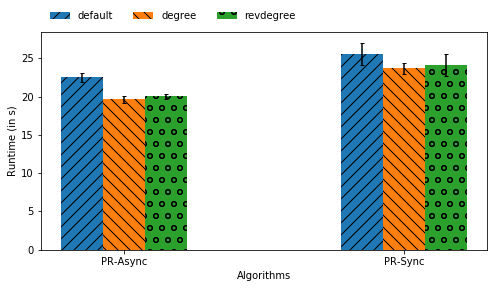

In [43]:
datafile_base = "../scripts/graphchi/stats/kron/kron"
benchmarks = ["pr"]
full_names = {"pr" : "PageRank"}
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("graphchi", benchmark, datafile_base, suffixes)
    plt.show()

## Soc_Livejournal

PageRank


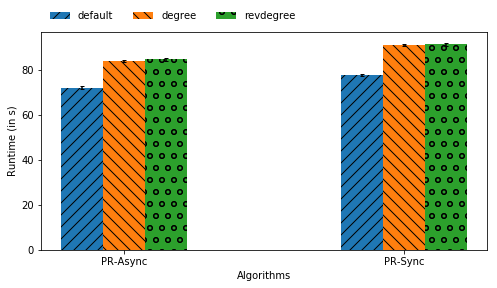

In [44]:
datafile_base = "../scripts/graphchi/stats/soc_livejournal/soc-livejournal"
benchmarks = ["pr"]
full_names = {"pr" : "PageRank"}
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("graphchi", benchmark, datafile_base, suffixes)
    plt.show()

## Parmat

PageRank


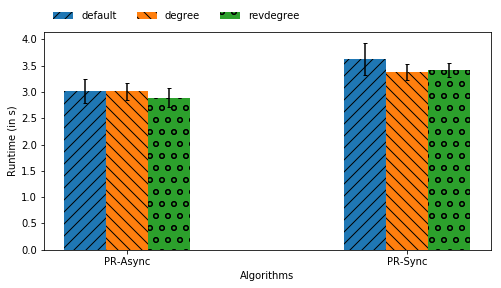

In [45]:
datafile_base = "../scripts/graphchi/stats/parmat/parmat"
benchmarks = ["pr"]
full_names = {"pr" : "PageRank"}
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("graphchi", benchmark, datafile_base, suffixes)
    plt.show()

# Results - Galois

In [6]:
suffixes = ["-default", "-degree", "-revdegree"]
nz_suffixes = ["-default_nz", "-degree_nz", "-revdegree_nz", "-random_nz"]

## Twitter

PageRank


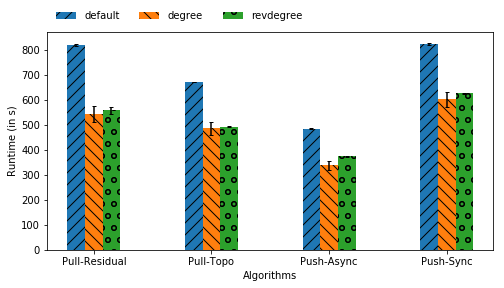

ConnectedComponents


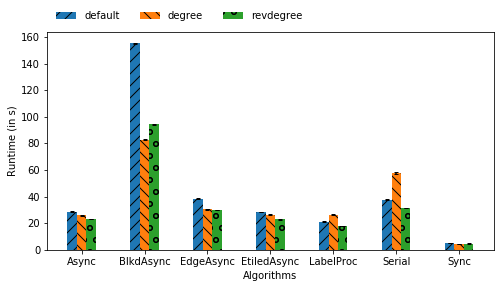

In [7]:
datafile_base = "../scripts/galois/stats/twitter_rv/twitter_rv"
benchmarks = ["pr", "cc"]
full_names = {"pr" : "PageRank", "cc" : "ConnectedComponents"}
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("galois", benchmark, datafile_base, suffixes)
    plt.show()

### Caching for PageRank

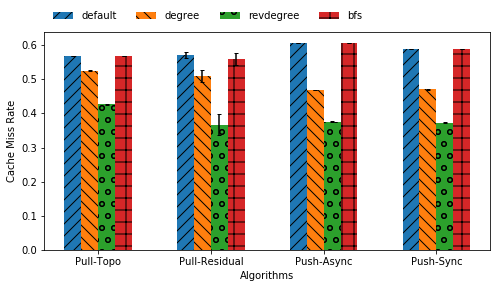

In [8]:
datafile = "../scripts/galois/stats/twitter_rv/twitter_rv_pr_cache.csv"
plot_cache('twitter_rv_pr_cache', datafile)

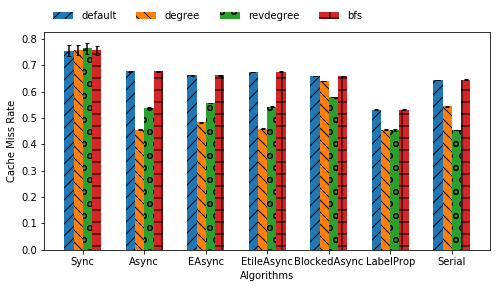

In [67]:
datafile = "../scripts/galois/stats/twitter_rv/twitter_rv_cc_cache.csv"
plot_cache('twitter_rv_cc_cache', datafile)

### Effect of Zero Vertices

PageRank


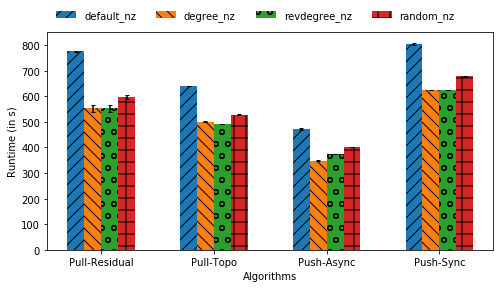

ConnectedComponents


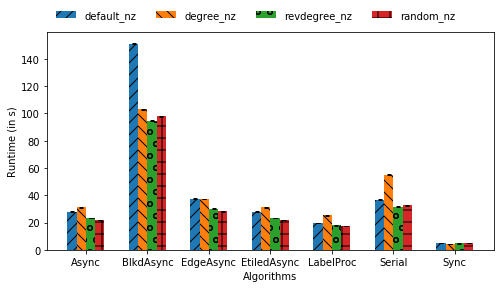

In [49]:
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("galois", benchmark, datafile_base, nz_suffixes)
    plt.show()

PageRank


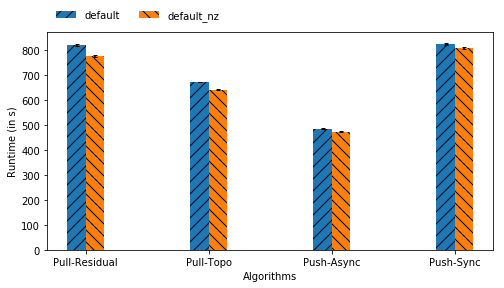

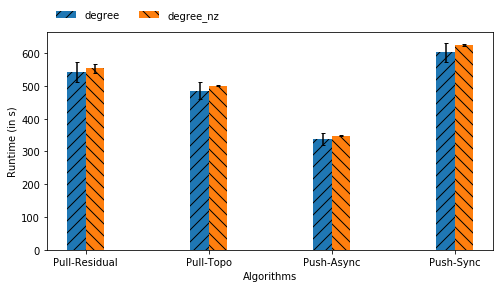

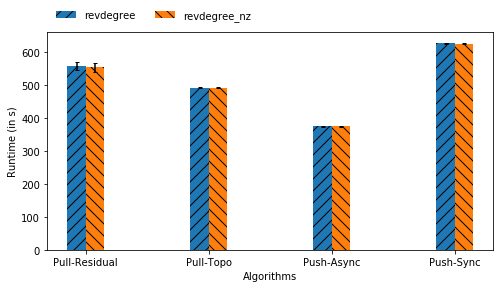

ConnectedComponents


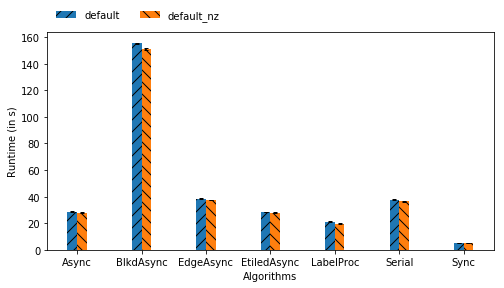

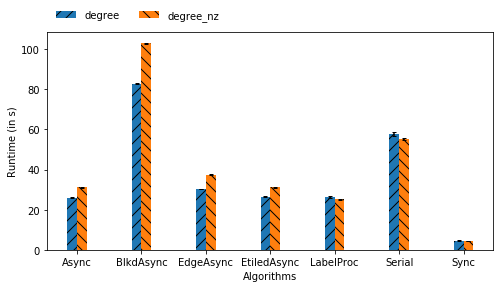

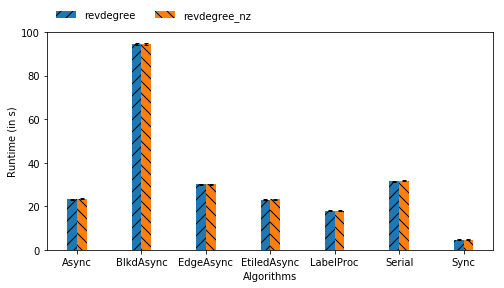

In [50]:
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_comparison("galois", "default", datafile_base, benchmark)
    plt.show()
    plot_comparison("galois", "degree", datafile_base, benchmark)
    plt.show()
    plot_comparison("galois", "revdegree", datafile_base, benchmark)
    plt.show()

## Soc Livejournal

PageRank


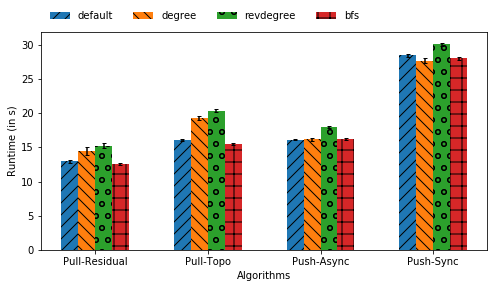

ConnectedComponents


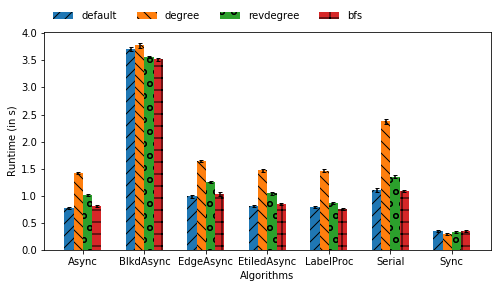

TriangleCounting


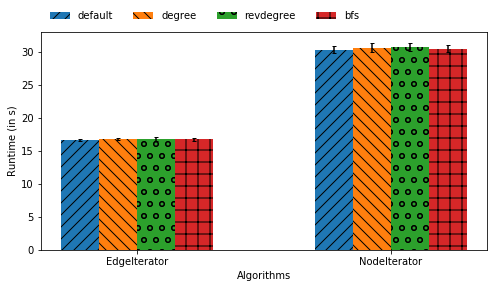

In [51]:
datafile_base = "../scripts/galois/stats/soc_livejournal/soc-livejournal"
benchmarks = ["pr", "cc", "tc"]
full_names = {"pr" : "PageRank", "cc" : "ConnectedComponents", "tc" : "TriangleCounting"}
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("galois", benchmark, datafile_base, suffixes)
    plt.show()

## Effect of Zero Vertices

PageRank


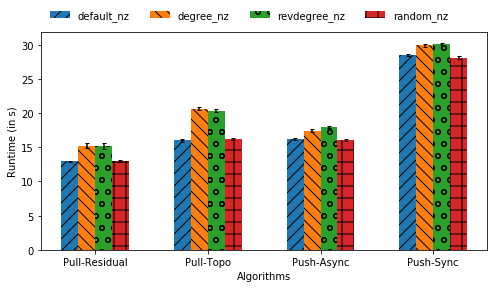

ConnectedComponents


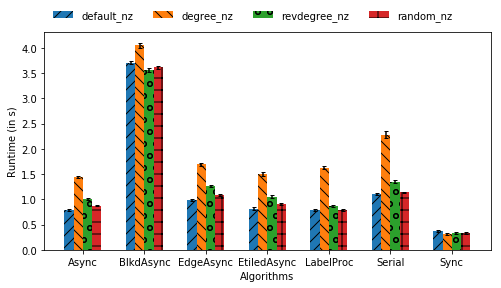

In [52]:
benchmarks = ["pr", "cc"]
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("galois", benchmark, datafile_base, nz_suffixes)
    plt.show()

PageRank


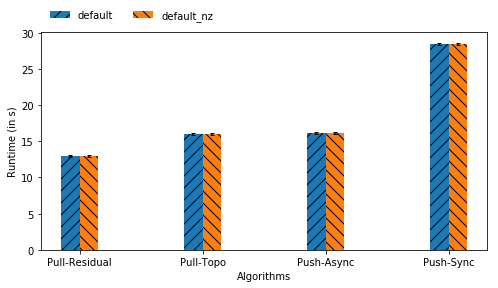

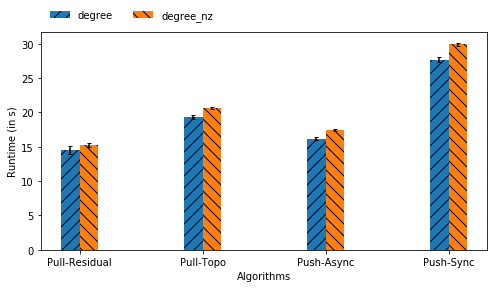

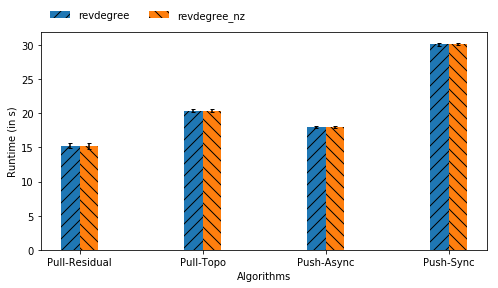

ConnectedComponents


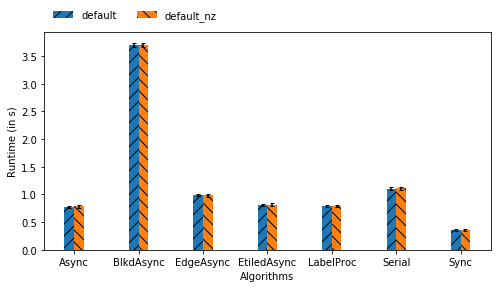

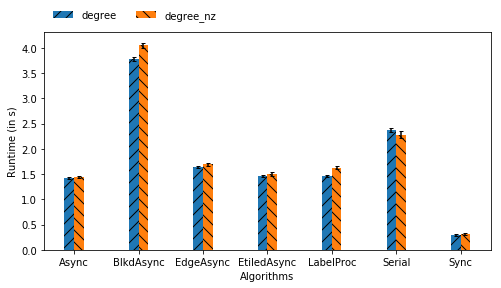

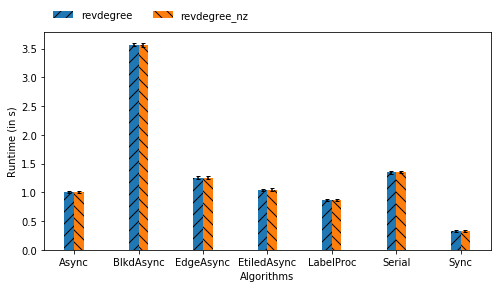

In [53]:
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_comparison("galois", "default", datafile_base, benchmark)
    plt.show()
    plot_comparison("galois", "degree", datafile_base, benchmark)
    plt.show()
    plot_comparison("galois", "revdegree", datafile_base, benchmark)
    plt.show()

## Cit Patents

PageRank


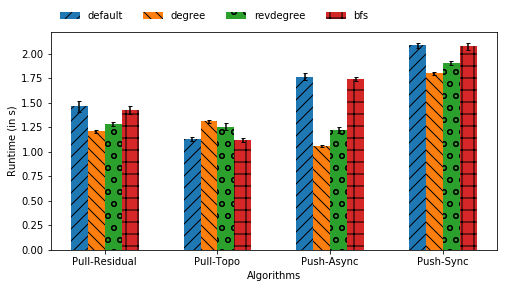

ConnectedComponents


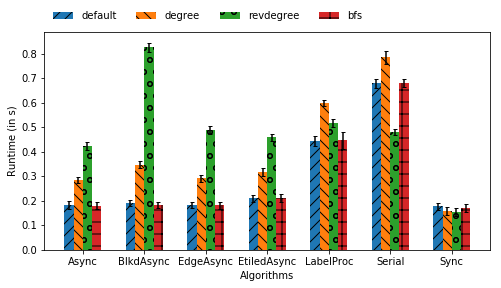

TriangleCounting


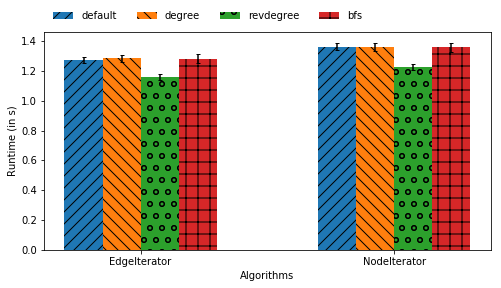

In [54]:
datafile_base = "../scripts/galois/stats/cit_patents/cit_patents"
benchmarks = ["pr", "cc", "tc"]
full_names = {"pr" : "PageRank", "cc" : "ConnectedComponents", "tc" : "TriangleCounting"}
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("galois", benchmark, datafile_base, suffixes)
    plt.show()

### Caching in Pagerank

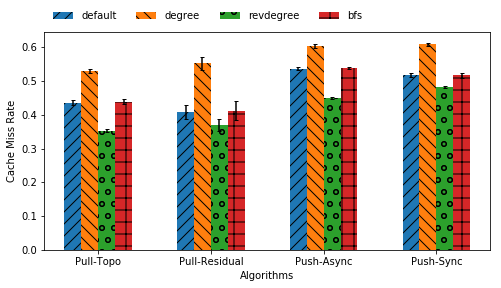

In [55]:
datafile = "../scripts/galois/stats/cit_patents/cit_patents_pr_cache.csv"
plot_cache('cit_patents_pr_cache', datafile)

## Effect of Zero Vertices

PageRank


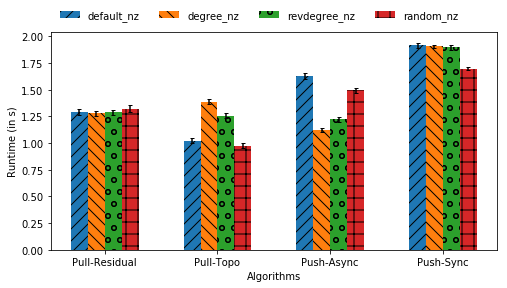

ConnectedComponents


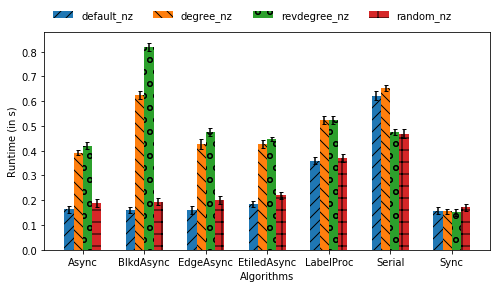

In [56]:
benchmarks = ["pr", "cc"]
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("galois", benchmark, datafile_base, nz_suffixes)
    plt.show()

PageRank


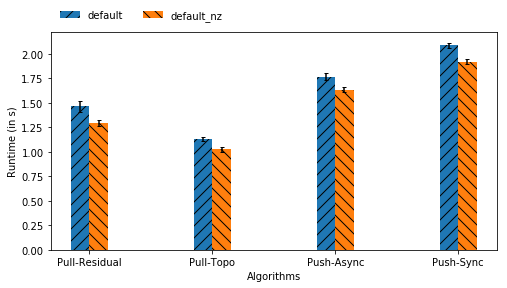

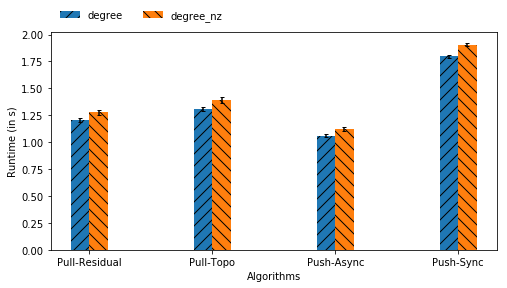

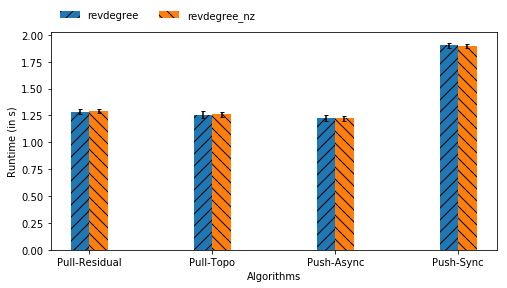

ConnectedComponents


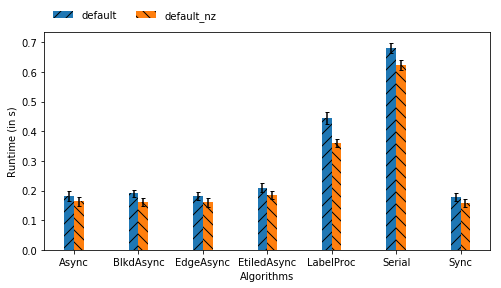

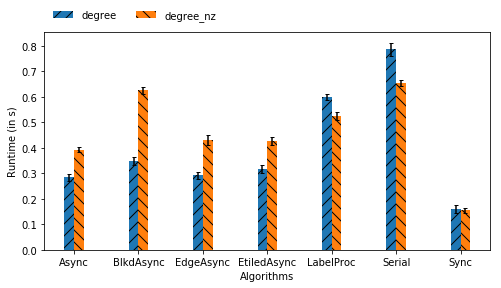

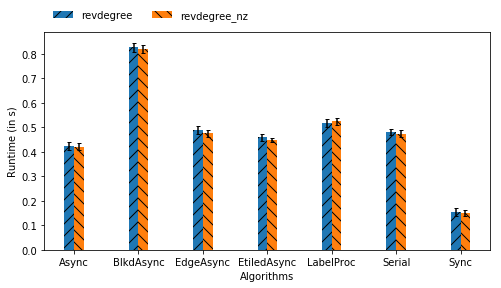

In [57]:
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_comparison("galois", "default", datafile_base, benchmark)
    plt.show()
    plot_comparison("galois", "degree", datafile_base, benchmark)
    plt.show()
    plot_comparison("galois", "revdegree", datafile_base, benchmark)
    plt.show()

## Smooth Kronecker

PageRank


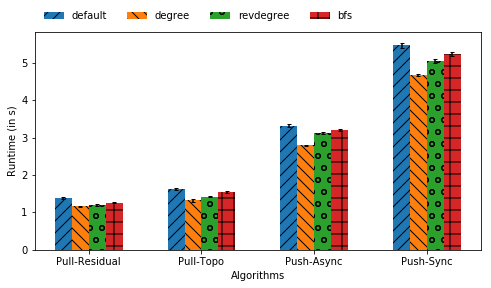

ConnectedComponents


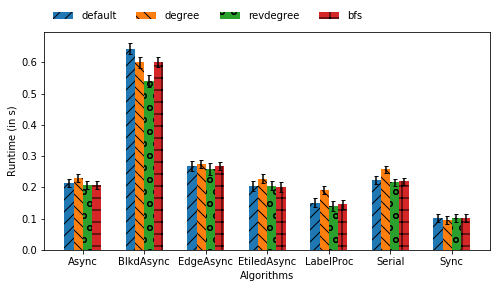

TriangleCounting


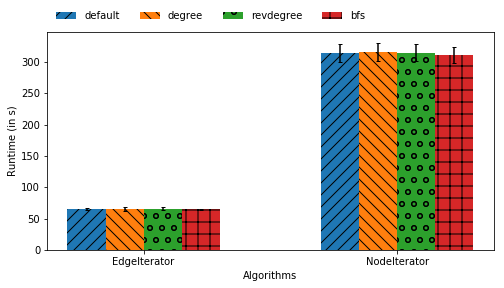

In [58]:
datafile_base = "../scripts/galois/stats/kron/kron"
benchmarks = ["pr", "cc", "tc"]
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("galois", benchmark, datafile_base, suffixes)
    plt.show()

### Caching for PageRank

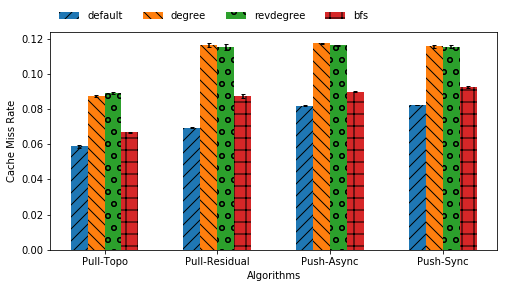

In [59]:
datafile = "../scripts/galois/stats/kron/kron_pr_cache.csv"
plot_cache('kron_pr_cache', datafile)

### Effect of Zero Vertices

PageRank


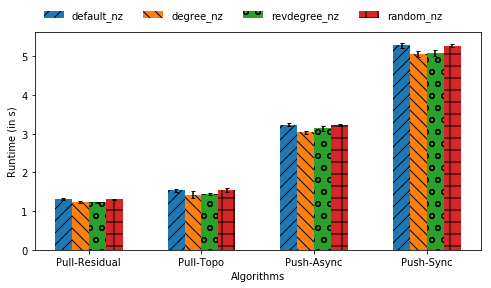

ConnectedComponents


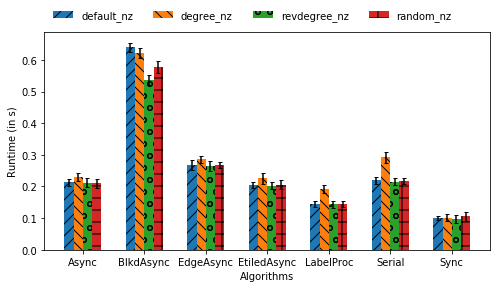

In [60]:
benchmarks = ["pr", "cc"]
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("galois", benchmark, datafile_base, nz_suffixes)
    plt.show()

PageRank


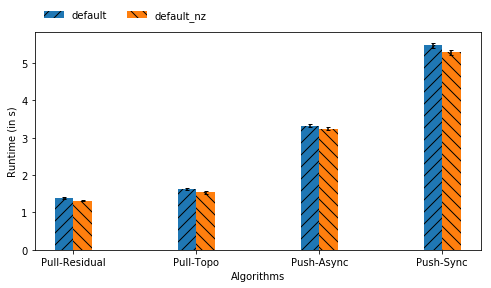

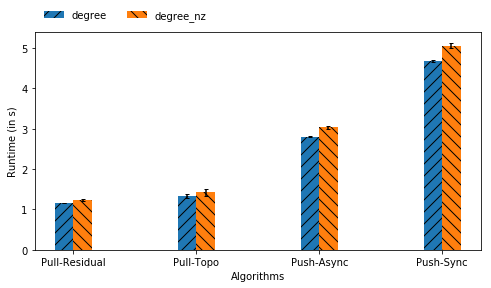

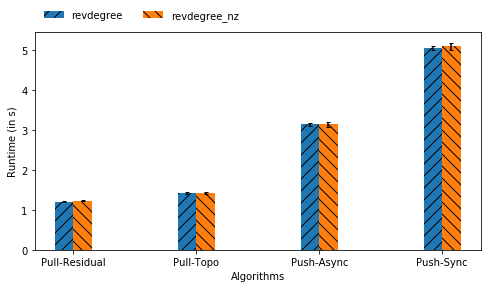

ConnectedComponents


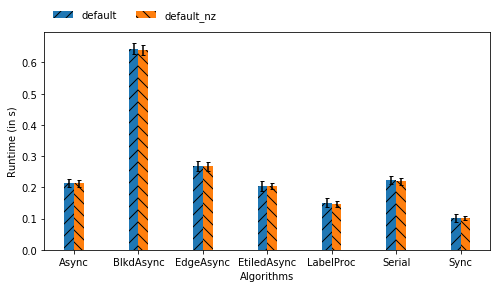

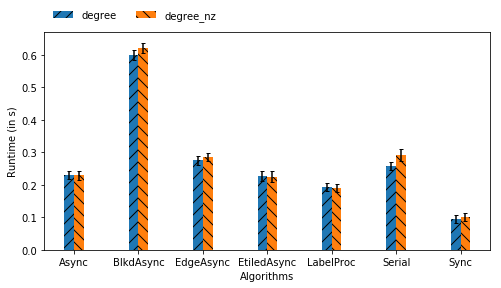

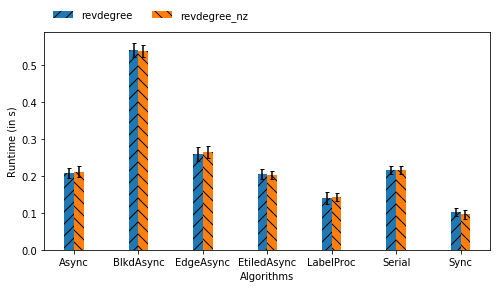

In [61]:
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_comparison("galois", "default", datafile_base, benchmark)
    plt.show()
    plot_comparison("galois", "degree", datafile_base, benchmark)
    plt.show()
    plot_comparison("galois", "revdegree", datafile_base, benchmark)
    plt.show()

## PaRMAT

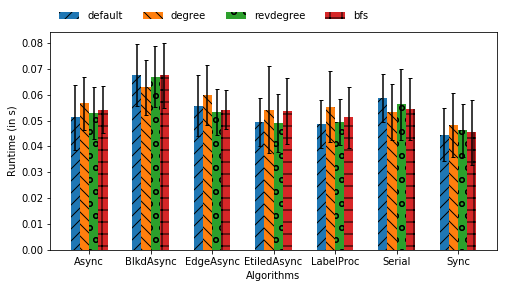

In [62]:
datafile_base = "../scripts/galois/stats/parmat/parmat"
plot_bars_with_errors("galois", benchmark, datafile_base, suffixes)
plt.show()

### Caching for PageRank

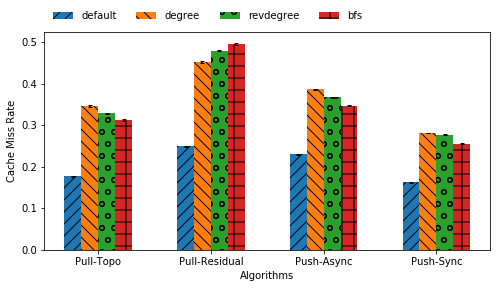

In [63]:
datafile = "../scripts/galois/stats/parmat/parmat_pr_cache.csv"
plot_cache('parmat_pr_cache', datafile)

### Effect of Zero Vertices

PageRank


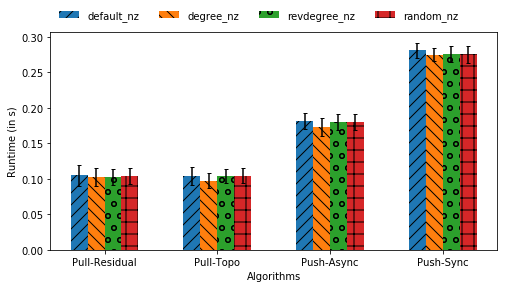

ConnectedComponents


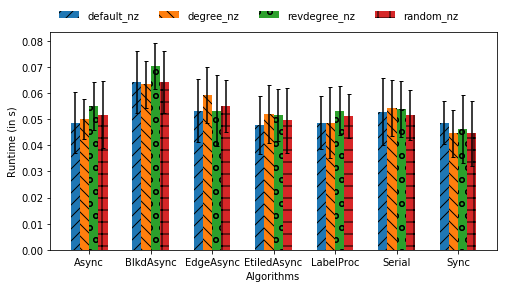

In [64]:
benchmarks = ["pr", "cc"]
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_bars_with_errors("galois", benchmark, datafile_base, nz_suffixes)
    plt.show()

PageRank


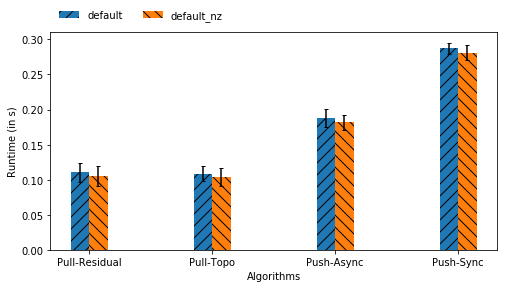

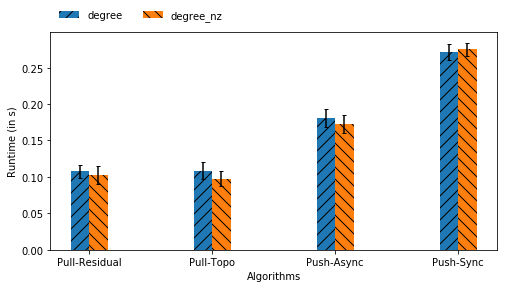

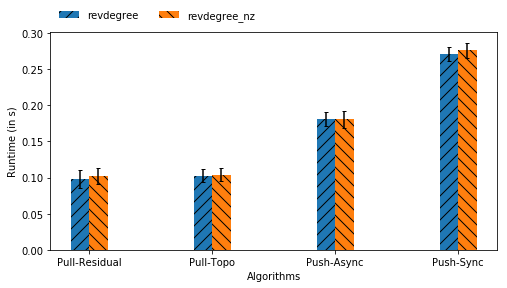

ConnectedComponents


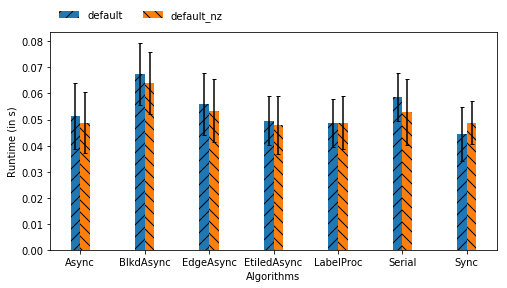

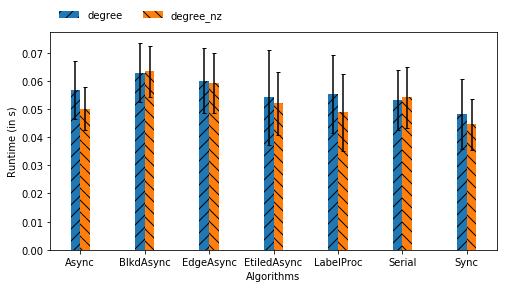

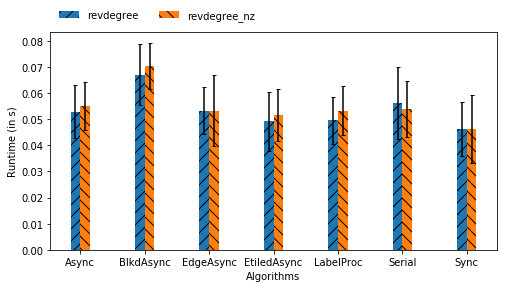

In [65]:
for benchmark in benchmarks:
    print(full_names[benchmark])
    plot_comparison("galois", "default", datafile_base, benchmark)
    plt.show()
    plot_comparison("galois", "degree", datafile_base, benchmark)
    plt.show()
    plot_comparison("galois", "revdegree", datafile_base, benchmark)
    plt.show()

## BFS Experiments

In [103]:
def plot_bfs(name, filename, colname):
    data = pd.read_csv(filename)
    algorithms = get_algo_names(filename)
    algorithms = np.unique(algorithms)
    vertices = np.unique(data["Vertex_ID"])
    nz_values = []
    nz_errs = []
    z_values = []
    z_errs = []
    for algorithm in algorithms:
        alg_filter = data["Algorithm"] == algorithm
        alg_data = data[alg_filter]
        nonzerodeg_filter = alg_data["Vertex_ID"] != 0
        zerodeg_filter = alg_data["Vertex_ID"] == 0
        nzdata = alg_data[nonzerodeg_filter]
        zdata = alg_data[zerodeg_filter]
        nz_value = np.mean(nzdata[colname].values)
        nz_err = np.std(nzdata[colname].values)
        z_value = np.mean(zdata[colname].values)
        z_err = np.std(zdata[colname].values)
        nz_values += [nz_value]
        nz_errs += [nz_err]
        z_values += [z_value]
        z_errs += [z_err]
    plot_data = [nz_values, z_values]
    print(nz_values, z_values)
    err_data = [nz_errs, z_errs]
    plot_vertical_bars_errors(name, plot_data, algorithms, ["Non-Zero Deg Vertex", "Zero Deg Vertex"], "Runtime (in s)", (8,4), "Algorithms", err_data)

[31.972380952380952, 34.064285714285717, 32.195714285714288, 30.429523809523808, 30.593333333333334, 31.189047619047621] [5.4199999999999999, 5.3450000000000006, 5.3799999999999999, 5.3300000000000001, 5.4050000000000002, 5.5099999999999998]
[34.453333333333333, 34.908571428571427, 33.378571428571433, 32.238095238095241, 32.5352380952381, 34.522380952380956] [5.2550000000000008, 5.4550000000000001, 5.625, 5.3650000000000002, 5.4649999999999999, 5.8000000000000007]


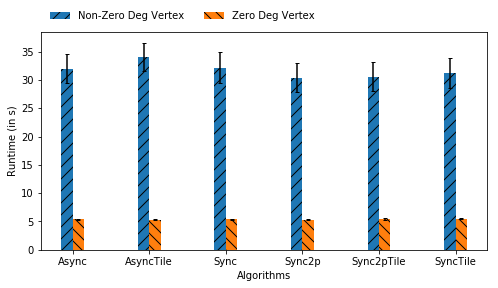

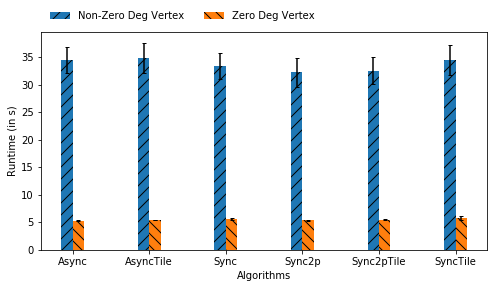

In [104]:
plot_bfs("galois_bfs_serial_twitter","../scripts/galois/stats/twitter_rv/twitter_rv-default-bfs-serial-sanitized.csv", "User")
plot_bfs("galois_bfs_parallel_twitter","../scripts/galois/stats/twitter_rv/twitter_rv-default-bfs-parallel-sanitized.csv", "User")

In [117]:
def plot_gemini_bfs(name, filename, column):
    alg_data = pd.read_csv(filename)
    nonzerodeg_filter = alg_data["Vertex_ID"] != 0
    zerodeg_filter = alg_data["Vertex_ID"] == 0
    nzdata = alg_data[nonzerodeg_filter]
    zdata = alg_data[zerodeg_filter]
    nz_value = np.mean(nzdata[column].values)
    nz_err = np.std(nzdata[column].values)
    z_value = np.mean(zdata[column].values)
    z_err = np.std(zdata[column].values)
    print(nz_value, nz_err, z_value, z_err)
    means = [nz_value, z_value]
    errs = [nz_err, z_err]
    x_pos = np.arange(2)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(x_pos, means, yerr=errs, width=0.2)
    ax.set_xlabel("Type of Vertex")
    ax.set_ylabel("Runtime (in s)")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(["Non-Zero Degree", "Zero Degree"])
    plt.savefig(name + ".png", bobx_inches="tight")

0.939329047619 0.120193871515 0.093341 0.002041


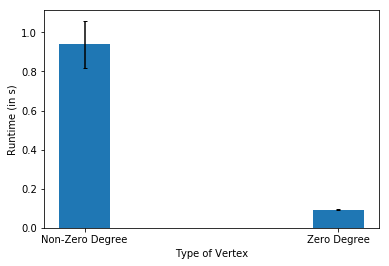

In [118]:
plot_gemini_bfs("gemini_bfs_twitter", "../scripts/gemini/stats/twitter_rv/twitter_rv-default-bfs.csv", "Exec")

In [138]:
orderings = ["default", "degree", "revdegree"]
algorithms = ["PR-Async", "PR-Sync"]
def plot_graphchi_cache(name, filename):
    df = pd.read_csv(filename)
    data = []
    errs = []
    for o in orderings:
        ordering_filter = df["Ordering"] == o
        ordered_df = df[ordering_filter]
        ordered_data = []
        ordered_err = []
        for alg in algorithms:
            alg_filter = ordered_df["Algorithm"] == alg
            alg_df = ordered_df[alg_filter]
            filtered_data = alg_df["Percentage"].values[1:]
            val = np.mean(filtered_data)
            err = np.std(filtered_data)
            ordered_data += [val]
            ordered_err += [err]
        data += [ordered_data]
        errs += [ordered_err]
    plot_vertical_bars_errors(name, data, algorithms, orderings, "Cache Miss Rate", (8,4), "Algorithms", errs)

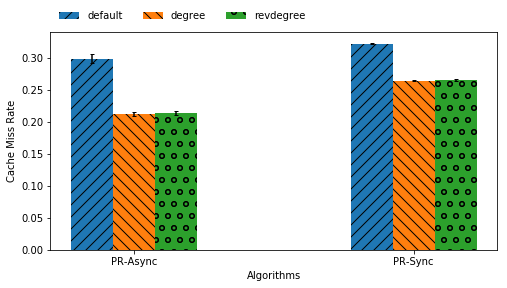

In [139]:
plot_graphchi_cache("graphchi_twitter_pr_cache", "../scripts/graphchi/stats/twitter_rv/graphchi_twitter_cache_pr.csv")